In [1]:
import pandas as pd

#import data
#angles
angles0_45 = pd.read_csv("torqueangles_0to45.csv",sep=",",header=None)
angles30_150 = pd.read_csv("torqueangles_30to150.csv",sep=",",header=None)

# Notbook Amp+Gauss Data
dataSR = pd.read_csv("TorqueMeasurement_SR_120825_all.csv",sep=",",header=None)

In [2]:
import numpy as np

def sem(x):
    return x.std(ddof=1) / np.sqrt(x.count())

In [3]:
# --- angles 0–45 ---
angles0_45_stats = pd.DataFrame({
    "mean": angles0_45.mean(),
    "std":  angles0_45.std(ddof=1),
    "sem":  angles0_45.apply(sem)
})

# --- angles 30–150 ---
angles30_150_stats = pd.DataFrame({
    "mean": angles30_150.mean(),
    "std":  angles30_150.std(ddof=1),
    "sem":  angles30_150.apply(sem)
})


In [4]:
# statistics
dataSR_stats = pd.DataFrame({
    "mean": dataSR.mean(),
    "std":  dataSR.std(ddof=1),
    "sem":  dataSR.apply(sem)
})
dataSR_stats

,mean,std,sem
0,-0.000890,0.000123,0.000012
1,0.110160,0.000136,0.000014
2,0.129378,0.000133,0.000013
3,0.140150,0.000135,0.000014
4,0.188277,0.000131,0.000013
5,0.265724,0.000321,0.000032
6,0.373280,0.000121,0.000012
7,0.395002,0.000123,0.000012


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_std(stats_df, title, ylabel):
    x = np.arange(1, len(stats_df) + 1)

    plt.figure()
    plt.errorbar(
        x,
        stats_df["mean"],
        yerr=stats_df["std"],
        fmt='.',
        capsize=4
    )

    plt.xlabel("Column index")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


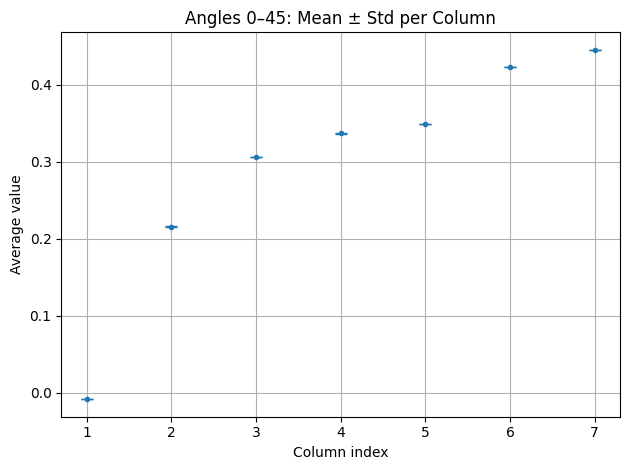

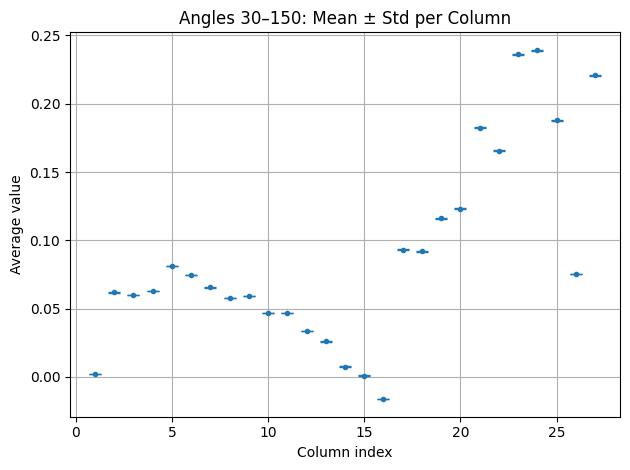

In [6]:
plot_mean_std(
    angles0_45_stats,
    title="Angles 0–45: Mean ± Std per Column",
    ylabel="Average value"
)

plot_mean_std(
    angles30_150_stats,
    title="Angles 30–150: Mean ± Std per Column",
    ylabel="Average value"
)


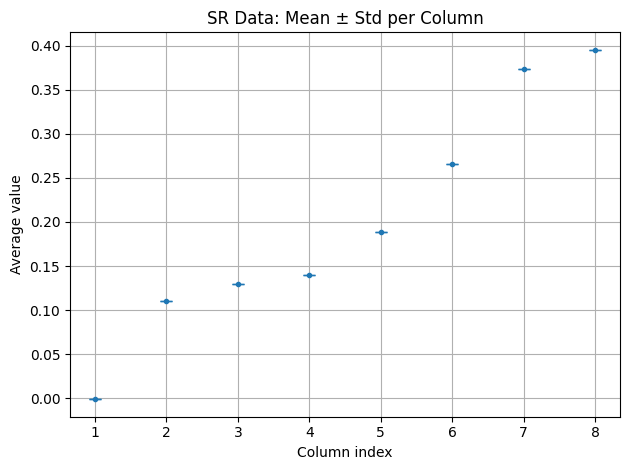

In [7]:
plot_mean_std(
    dataSR_stats,
    title="SR Data: Mean ± Std per Column",
    ylabel="Average value"
)


In [8]:
# Bfield ({values}) Gauss
Bfield_gauss = [(0),(180),(203,212,206,210),(230,240,240,230),
         (250,250,280,280),(280),(150),(125)]

In [17]:
# Convert Gauss to Tesla (1 Tesla = 10,000 Gauss)
Bfield_tesla = []
for val in Bfield_gauss:
    if isinstance(val, (int, float)):
        Bfield_tesla.append(val / 10000)
    else:
        Bfield_tesla.append(tuple(v / 10000 for v in val))


# Extract index, mean and std
rows = []
for val in Bfield_tesla:
    if isinstance(val, (int, float)):
        values = [val]
    else:
        values = list(val)          # in case it's a tuple
    
    mean_val = np.mean(values)
    std_val  = np.std(values, ddof=0) if len(values) > 1 else 0.0   # population std
    
    rows.append({'mean': mean_val, 'std': std_val})

df = pd.DataFrame(rows)
df = df.sort_values('mean').reset_index(drop=True)

In [18]:
df_voltage = dataSR_stats.rename(columns={
    'mean': 'Voltage Mean',
    'std':  'Voltage Std',
    'sem':  'Voltage SEM'
})

df_bfield = df.rename(columns={
    'mean': 'Bfield Mean',
    'std':  'Bfield Std'
})
df_voltage,df_bfield

(   Voltage Mean  Voltage Std  Voltage SEM
 0     -0.000890     0.000123     0.000012
 1      0.110160     0.000136     0.000014
 2      0.129378     0.000133     0.000013
 3      0.140150     0.000135     0.000014
 4      0.188277     0.000131     0.000013
 5      0.265724     0.000321     0.000032
 6      0.373280     0.000121     0.000012
 7      0.395002     0.000123     0.000012,
    Bfield Mean  Bfield Std
 0     0.000000    0.000000
 1     0.012500    0.000000
 2     0.015000    0.000000
 3     0.018000    0.000000
 4     0.020775    0.000349
 5     0.023500    0.000500
 6     0.026500    0.001500
 7     0.028000    0.000000)

In [19]:
df_combined = pd.concat([
    df_bfield,
    df_voltage
], axis=1)

df_combined = df_combined[[
    'Bfield Mean', 'Bfield Std',
    'Voltage Mean', 'Voltage Std', 'Voltage SEM'
]]
df_combined_clean = df_combined[df_combined['Bfield Mean'] != 0].reset_index(drop=True)
df=df_combined_clean

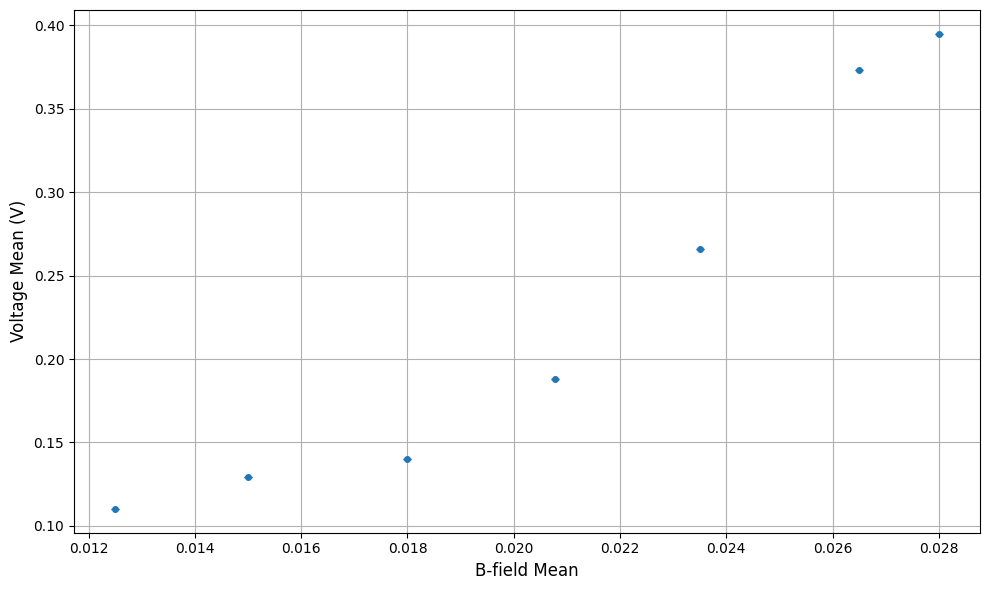

In [20]:
plt.figure(figsize=(10, 6))

plt.errorbar(
    x=df['Bfield Mean'],
    y=df['Voltage Mean'],
    yerr=df['Voltage SEM'],
    fmt='o', markersize=4, capsize=3, label="data"  
)

plt.xlabel('B-field Mean', fontsize=12)
plt.ylabel('Voltage Mean (V)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
r = 0.05  # meters
sigma_r = 0.0005  # meters
slope_mg = 3.5063e-5  # V/mg
sigmaV = 0.002  # V

# Convert slope to V/N
mg_to_N = 9.80665e-6
slope_V_per_N = slope_mg / mg_to_N

def voltage_to_tau(voltage):
    F = np.abs(voltage) / slope_V_per_N
    tau = r * F
    return tau, F

df[['tau_max', 'F']] = df['Voltage Mean'].apply(voltage_to_tau).tolist()
df['sigma_tau'] = df['tau_max'] * np.sqrt( (slope_V_per_N * sigmaV/df['Voltage Mean'])**2 + (sigma_r/r)**2 )

df

,Bfield Mean,Bfield Std,Voltage Mean,Voltage Std,Voltage SEM,tau_max,F,sigma_tau
0,0.012500,0.000000,0.110160,0.000136,0.000014,0.001541,0.030810,0.000101
1,0.015000,0.000000,0.129378,0.000133,0.000013,0.001809,0.036185,0.000102
2,0.018000,0.000000,0.140150,0.000135,0.000014,0.001960,0.039198,0.000102
3,0.020775,0.000349,0.188277,0.000131,0.000013,0.002633,0.052658,0.000103
4,0.023500,0.000500,0.265724,0.000321,0.000032,0.003716,0.074319,0.000107
5,0.026500,0.001500,0.373280,0.000121,0.000012,0.005220,0.104401,0.000113
6,0.028000,0.000000,0.395002,0.000123,0.000012,0.005524,0.110477,0.000114


In [22]:
from scipy.optimize import curve_fit
import numpy as np

def fit_voltage_parabola(xdata, ydata, yerr=None, mode="quadratic"):
    """
    Fit V(B) using different models.
    
    Parameters
    ----------
    xdata, ydata : arrays
    yerr : arrays, SEM for weighting
    mode : str
        "quadratic"      → V = a*B^2 + b*B + c
        "zero_intercept" → V = k*B^2
        "offset_only"    → V = k*B^2 + V0
    
    Returns
    -------
    popt : fitted parameters
    perr : parameter uncertainties (sqrt diag of covariance)
    model : callable model function
    """

    if mode == "zero_intercept":
        def model(B, k):
            return k * B**2

    elif mode == "offset_only":
        def model(B, k, V0):
            return k * B**2 + V0

    elif mode == "quadratic":
        def model(B, a, b, c):
            return a*B**2 + b*B + c
    else:
        raise ValueError("mode must be 'quadratic', 'zero_intercept', or 'offset_only'")

    popt, pcov = curve_fit(
        model,
        xdata,
        ydata,
        sigma=yerr,
        absolute_sigma=True
    )
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr, model

def compute_chi2(x, y, yerr, popt, model):
    yfit = model(x, *popt)
    residuals = y - yfit
    chi2 = np.sum((residuals / yerr) ** 2)
    dof = len(y) - len(popt)
    reduced_chi2 = chi2 / dof if dof > 0 else np.nan
    return residuals, chi2, reduced_chi2


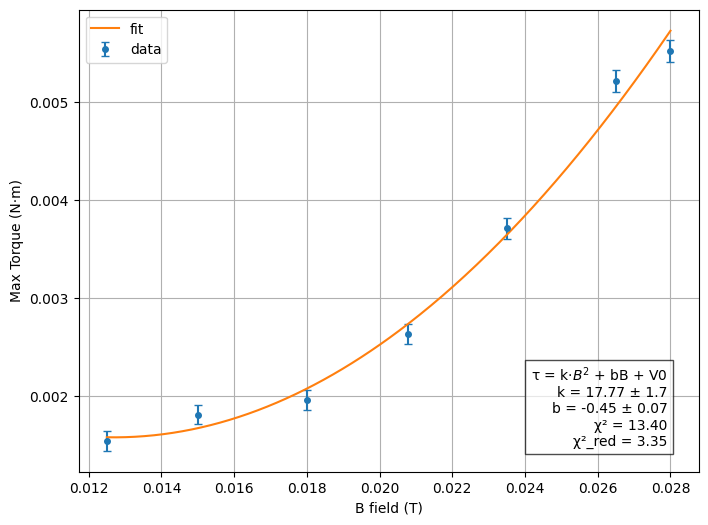

In [30]:
# Clean data
df_clean = df
xdata = df_clean["Bfield Mean"].values
ydata = df_clean["tau_max"].values
yerr = df_clean["sigma_tau"].values

# Fit zero_intercept
popt, perr, model = fit_voltage_parabola(
    xdata, ydata, yerr=yerr, mode="quadratic"
)

# Chi2
residuals, chi2, reduced_chi2 = compute_chi2(xdata, ydata, yerr, popt, model)

k, b, V0 = popt
k_err, b_err, V0_err = perr

# Fit line for plotting
xfit = np.linspace(np.min(xdata), np.max(xdata), 300)
yfit_plot = model(xfit, *popt)


plt.figure(figsize=(8,6))


#plt.title(f"{df_name} — Zero-Intercept Fit (Torque)")
plt.xlabel("B field (T)")
plt.ylabel("Max Torque (N·m)")

# Data
plt.errorbar(xdata, ydata, yerr=yerr, fmt='o', markersize=4, capsize=3, label="data")
plt.plot(xfit, yfit_plot, '-', label="fit")

# Fit text box — bottom-right
fit_text = (
    f"τ = k·$B^2$ + bB + V0\n"
    f"k = {k:.2f} ± {k_err:.1f}\n"
    f"b = {b:.2f} ± {b_err:.2f}\n"
    #f"V0 = {V0:.3e} ± {V0_err:.1e}\n"
    f"χ² = {chi2:.2f}\n"
    f"χ²_red = {reduced_chi2:.2f}"
)

ax = plt.gca()
ax.text(0.95, 0.05, fit_text,  # bottom-right
        transform=ax.transAxes,
        va='bottom', ha='right',
        bbox=dict(facecolor='white', alpha=0.7))

plt.legend(loc='best')
plt.grid(True)
plt.savefig('example_plotS.png', dpi=300, bbox_inches='tight')  # PNG format
plt.show()


In [39]:
# -----------------------------
# Compute susceptibility
# chi = 2 k mu / Vol
# -----------------------------

mu0 = 4*np.pi*1e-7     # vacuum permeability

l = 0.02 #2cm
d = 0.005 #5mm
r = d/2
Vol = np.pi * r**2 * l
chi = 2 * k * mu0 / Vol
chi_err = chi * np.sqrt((k_err/k)**2)

print(Vol)
print(f"chi = {chi:.3f} ± {chi_err:.2f}")

3.9269908169872417e-07
chi = 113.754 ± 11.01
